# CNN: CSRNET

# Load data

## Import annotations

In [1]:
import os 
import tensorflow as tf

### Get the dataset working directory

In [2]:
microplastics_dir = os.path.join(os.getcwd(), "microplastic-dataset")

### Check annotations directory

In [3]:
annotations = [];

# folder names
folder_annotations = ["train/annotation", "valid/annotation", "test/annotation"]
for folder_annotation in folder_annotations:
    paths = os.path.join(microplastics_dir, folder_annotation)
    if os.path.exists(paths):
        files = os.listdir(paths)
        ## get the each files directory
        for file in files:
            if(file.endswith(".csv")): annotations.append(os.path.join(paths, file))
    else:
        print (f"{folder_annotation} file is not found")

### Images directory

In [4]:
train_images = os.path.join(microplastics_dir,"train" ,"images/adjusted") 
train_img_paths = [os.path.join(train_images, f)
                   for f in os.listdir(train_images)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]

valid_images = os.path.join(microplastics_dir,"valid", "images/adjusted") 
valid_img_paths = [os.path.join(valid_images, f)
                   for f in os.listdir(valid_images)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]

test_images = os.path.join(microplastics_dir, "test", "images/adjusted") 
test_img_paths = [os.path.join(test_images, f)
                   for f in os.listdir(test_images)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]

## View annotation contents

Dataset is split into train= 70%, validation= 15%, test= 15%

In [5]:
import pandas as pd

In [6]:
train = ""
valid = ""
test = ""

for annotation in annotations:
    path_name = os.path.basename(annotation)
    if ("train" in path_name):
        train = annotation
    elif ("valid" in path_name):
        valid = annotation
    elif ("test" in path_name):
        test = annotation

In [8]:
# print(test)

In [9]:
# print(train)

In [10]:
# print(valid)

In [7]:
train_ds = pd.read_csv(train)
valid_ds = pd.read_csv(valid)
test_ds = pd.read_csv(test)

### Train Dataset

In [8]:
train_df = pd.DataFrame(train_ds)
train_df.columns = ['class', 'x', 'y', 'image', 'height', 'width']
train_df.head()

,class,x,y,image,height,width
0,microplastic,538,336,microplastics_1.jpg,1008,1008
1,microplastic,569,412,microplastics_1.jpg,1008,1008
2,microplastic,490,138,microplastics_1.jpg,1008,1008
3,microplastic,470,140,microplastics_1.jpg,1008,1008
4,microplastic,524,155,microplastics_1.jpg,1008,1008


### Valid Dataset

In [9]:
valid_df = pd.DataFrame(valid_ds)
valid_df.columns = ['class', 'x', 'y', 'image', 'height', 'width']
valid_df.head()

,class,x,y,image,height,width
0,microplastic,374,449,microplastics_1.jpg,1008,1008
1,microplastic,386,353,microplastics_1.jpg,1008,1008
2,microplastic,364,344,microplastics_1.jpg,1008,1008
3,microplastic,430,333,microplastics_1.jpg,1008,1008
4,microplastic,177,676,microplastics_1.jpg,1008,1008


### Test Datset

In [10]:
test_df = pd.DataFrame(test_ds)
test_df.columns = ['class', 'x', 'y', 'image', 'height', 'width']
test_df.head()

,class,x,y,image,height,width
0,microplastic,645,496,microplastics_1.jpg,1008,1008
1,microplastic,361,584,microplastics_1.jpg,1008,1008
2,microplastic,774,843,microplastics_1.jpg,1008,1008
3,microplastic,728,427,microplastics_10.jpg,1008,1008
4,microplastic,679,344,microplastics_10.jpg,1008,1008


### Image prefetching

datasets for training

In [1]:
from skimage.transform import resize

In [11]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/ 255.0
    return img

# dataset prefetched for good performance
train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_paths)
train_img_ds =train_img_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_img_ds= train_img_ds.batch(1).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

valid_img_ds = tf.data.Dataset.from_tensor_slices(valid_img_paths)
valid_img_ds = valid_img_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_img_ds= valid_img_ds.batch(1).cache().prefetch(tf.data.AUTOTUNE)

test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_paths)
test_img_ds = test_img_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
test_img_ds= test_img_ds.batch(16).cache().prefetch(tf.data.AUTOTUNE)

checking if the images were normalize

In [12]:
# min
print(next(img for img in train_img_ds).numpy().min())
#max
print(next(img for img in train_img_ds).numpy().max())

0.0
1.0


### View image with the annotations

In [13]:
import matplotlib.image as image
import matplotlib.pyplot as plt


sample image annotated

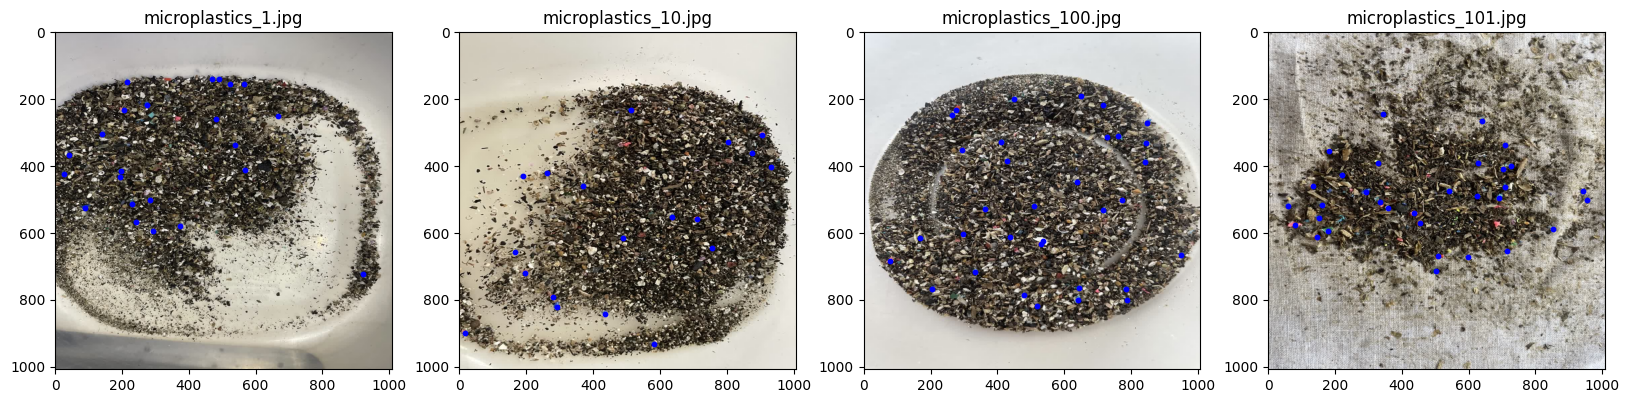

In [14]:
sample_data = train_df
# print(sample_data)
fig, axis = plt.subplots(ncols=4, figsize=(20,20))

for i, image_ in enumerate(sample_data['image'].unique()[:4]):
    points = sample_data[sample_data['image'] == image_]
    x_pos = points['x']
    y_pos = points['y']
    selected_image = points['image']
    selected_image = next(img for img in train_img_paths if os.path.basename(img) == image_)
    
    axis[i].imshow(image.imread(selected_image))
    axis[i].set_title(os.path.basename(selected_image))
    axis[i].scatter(x_pos, y_pos, c="blue", s=10)
plt.show()

# Create Density Map (Guassian filter)

In [15]:
from scipy.ndimage import gaussian_filter
import numpy as np

In [16]:
def create_density_map(df_, target_size=(126, 126)):
    density_maps = []
    fname_ = []
    for image_name in df_['image'].unique():
        img_points = df_[df_['image'] == image_name]

        h = img_points['height'].iloc[0]
        w = img_points['width'].iloc[0]
        
        # Create empty density map
        density_map = np.zeros((h, w), dtype=np.float32)
        
        # Place 1.0 at each point location
        for _, row in img_points.iterrows():
            x, y = int(row['x']), int(row['y'])
            if 0 <= int(x) < w and 0 <= int(y) < h:
                density_map[y, x] = 1.0
        
        # Apply Gaussian filter
        density_map = gaussian_filter(density_map, sigma=15, mode="constant")

        # resize base on block4_conv3 downsampled
        density_map = resize(density_map, target_size, 
                           mode='constant', 
                           anti_aliasing=True,
                           preserve_range=True)
        
        density_maps.append(density_map)
        fname_.append(image_name)
    return density_maps, fname_

In [17]:
train_density_map = create_density_map(train_df)
valid_density_map = create_density_map(valid_df)

In [18]:
train_map,_= train_density_map
valid_map,_= valid_density_map

train_map_ds = tf.data.Dataset.from_tensor_slices(train_map)
valid_map_ds = tf.data.Dataset.from_tensor_slices(valid_map)

print(train_map[2].min())

0.0


## visualize density map

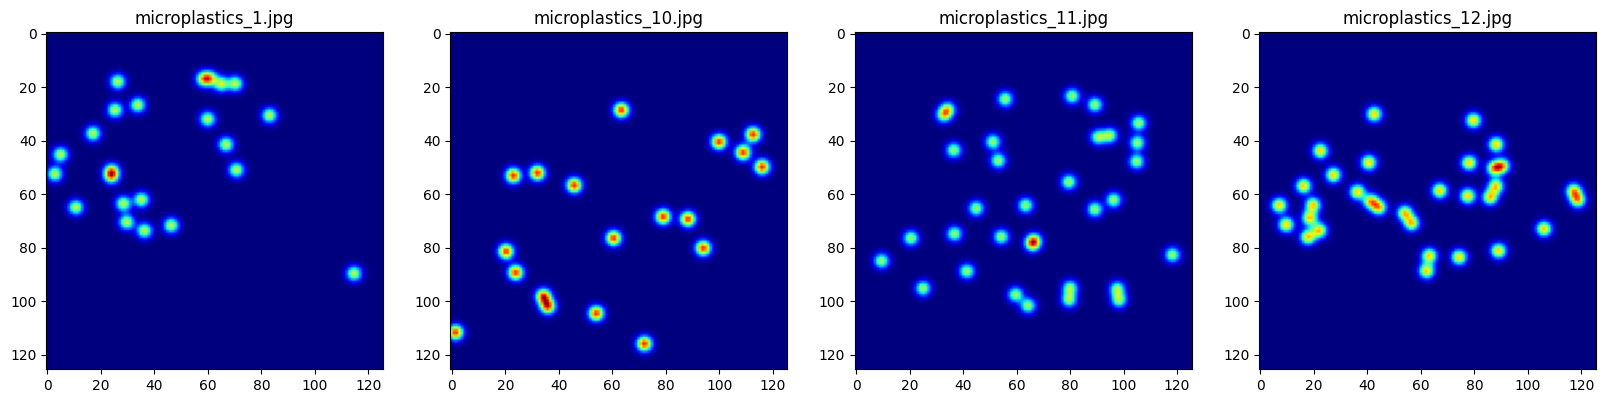

In [19]:
fig1, axis1 = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    axis1[i].imshow(train_map[i], cmap="jet")
    axis1[i].set_title(_[i])
plt.show()

# Building CSRNET

## Front end

In [22]:
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16

In [23]:
shape_=layers.Input(shape=(1008, 1008, 3))
def front_end(inp_shape):
    input_ = shape_

    # configure vgg16 for csrnet
    vgg_model = VGG16(include_top=False,
                weights="imagenet",
                input_tensor=input_)
    
    # freeze vgg layers for training  
    for layer in vgg_model.layers:
        layer.trainable = False

    # stop in the layer of block4_conv3 
    frontend_output = vgg_model.get_layer("block4_conv3").output

    # create model    
    frontend_model = Model(inputs=input_, outputs=frontend_output, name="CSRNet_Frontend")

    return frontend_model, frontend_output    

In [24]:
frontendModel, frontendOutput = front_end(shape_)
frontendModel.summary()   

Model: "CSRNet_Frontend"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1008, 1008, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 1008, 1008, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 1008, 1008, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 504, 504, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 504, 504, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 504, 504, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 252, 252, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 252, 252, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 252, 252, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 252, 252, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 126, 126, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 126, 126, 512)       │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 126, 126, 512)       │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,635,264 (29.13 MB)

## Gather test dataset images for testing getting the features

only use this for feature map visualization. this does not predict initially, it actually gets the feature of the image

In [25]:
features = frontendModel.predict(test_img_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 522s 109s/step


## Visualization of features gathered

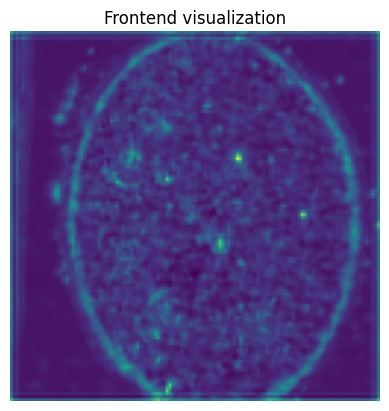

In [26]:
# print(features)
feat = features[3] 
plt.imshow(feat.mean(axis=-1), cmap="viridis")
plt.title("Frontend visualization")
plt.axis('off')
plt.show()

In [27]:
def back_end(x):
    # Backend (dilated conv layers)
    x = layers.Conv2D(512, 3, dilation_rate=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, dilation_rate=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, dilation_rate=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, dilation_rate=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, dilation_rate=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, dilation_rate=2, padding='same', activation='relu')(x)
    
    # Output density map
    density_map_output = layers.Conv2D(1, 1, padding='same', activation='relu')(x)

    csrnet_model = Model(inputs=shape_, outputs=density_map_output, name="CSRNet_Backend")

    return csrnet_model

In [28]:
backEnd = back_end(frontendOutput)
backEnd.summary()

Model: "CSRNet_Backend"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1008, 1008, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 1008, 1008, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 1008, 1008, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 504, 504, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 504, 504, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 504, 504, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 252, 252, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 252, 252, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 252, 252, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 252, 252, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 126, 126, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 126, 126, 512)       │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 512)       │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 16,263,489 (62.04 MB)

 Trainable params: 8,628,225 (32.91 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [29]:
backEnd.compile(
    optimizer="adam", 
    loss="mse", # standard loss
    metrics=['mae'] # useful for count difference
)

In [30]:
# for logging trainning of training and validation 
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="logs", # save logs
)

In [31]:
train_ds = tf.data.Dataset.zip((train_img_ds, train_map_ds))
valid_ds = tf.data.Dataset.zip((valid_img_ds, valid_map_ds))

In [ ]:
history = backEnd.fit(
    train_ds,
    validation_data=valid_ds, 
    epochs=50,
    callbacks=[tensorboard_callback]
)